# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### Part (1)

In [2]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [71]:
def extract_pts(matches):
    assert(matches.shape[1] == 4)

    num = matches.shape[0]

    pt1 = np.hstack([matches[:, :2], np.ones((num, 1))])
    # print(pt1.shape)
    # print(pt1)
    pt2 = np.hstack([matches[:, 2:], np.ones((num, 1))])
    # print(pt2.shape)

    # print(matches.shape)
    # print(pt1.shape)
    # print(pt2.shape)
    return pt1, pt2

def compute_fundamental(pt1, pt2):
    assert(pt1.shape[1] == 3)
    assert(pt1.shape == pt2.shape)

    num = pt1.shape[0]

    A = np.zeros((num, 9))
    for i in range(num):
        A[i] = np.kron(pt2[i], pt1[i])
        # A[i] = np.kron(pt1[i], pt2[i])
        # x, y, z = pt1[i]
        # x_, y_, z_ = pt2[i]

        # test = np.array([x*x_, x*y_, x, y*x_, y*y_, y, x_, y_, 1])
        # assert(test.all() == A[i].all())
    
    # print(A.shape)
    # print(A)

    U, S, V = np.linalg.svd(A)

    F = V[-1, :].reshape(3, 3)

    # F_2 = np.reshape(V[:, -1], (3, 3))

    # F_3 = np.reshape(V.T[:, -1], (3, 3))


    # print("F1", F)
    # print("F2", F_2)
    # print("F3", F_3)

    F_U, F_S, F_V = np.linalg.svd(F)


    # print(F_U.shape, F_S.shape, F_V.shape)
    # print("FU,FS,FV")

    F_S = np.diag(F_S)

    # print("FS")
    # print(F_S)
    # print(np.amin(F_S))

    F_S[-1, -1] = 0
    # print(F_U, F_S, F_V)
    # print(F_S)

    F = np.dot(np.dot(F_U, F_S), F_V)

    # F_2 = F_U @ F_S @ F_V

    # F_3 = np.matmul(F_U, np.matmul(F_S, F_V))

    # F_4 = np.dot(F_U, np.dot(F_S, F_V))

    # print("===================")
    # print(F)
    # print("===================")
    # print(F_2)
    # print("===================")
    # print(F_3)
    # print("===================")
    # print(F_4)
    return F


def rescale_data(pt):
    assert(pt.shape[1] == 3)

    pt_2d = pt[:, :2]
    print(pt_2d.shape)
    # print(pt_2d)

    mean = np.mean(pt_2d, axis=0)
    print(mean)
    print(mean.shape)
    sum_sq = np.sum(np.square(pt_2d - mean), axis=1)
    print(sum_sq.shape)

    mean_sum_sq = np.mean(sum_sq, axis=0)

    s = np.sqrt(2/mean_sum_sq)

    T = np.array([[s, 0, -s*mean[0]], [0, s, -s*mean[1]], [0, 0, 1]])
    print(T)

    pt_T = np.dot(T, pt.T).T
    print(pt_T)
    print(pt_T.shape)

    return T, pt_T

# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """

    pt1, pt2 = extract_pts(matches)

    F = compute_fundamental(pt1, pt2)
    
    return F


def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """

    pt1, pt2 = extract_pts(matches)

    T_1, pt1_T = rescale_data(pt1)
    T_2, pt2_T = rescale_data(pt2)

    F = compute_fundamental(pt1_T, pt2_T)

    F = np.dot(np.dot(T_2.T, F), T_1)

    return F


   ]
 [389.6875   228.25    ]
 [365.3335   296.875   ]
 [128.771    141.646   ]
 [307.4055   200.247   ]
 [161.725    171.225   ]
 [132.422    147.2655  ]
 [ 92.3125   196.25    ]
 [135.3055   153.222   ]
 [386.775    253.225   ]
 [307.828    258.547   ]
 [334.9875   259.0125  ]
 [142.2       42.35    ]
 [370.131     91.9285  ]
 [290.356    157.702   ]
 [380.378    285.177   ]
 [331.566    153.5075  ]
 [166.143    188.107   ]
 [219.159    241.5     ]
 [233.5265   199.2765  ]
 [ 85.581    202.9485  ]
 [124.5455   170.2045  ]
 [306.575    256.425   ]
 [296.409    319.7045  ]
 [389.6365   136.3865  ]
 [133.398     95.574   ]
 [286.99     253.48    ]
 [316.5      295.25    ]
 [258.6875   145.896   ]
 [411.896    244.896   ]
 [122.3055    93.5555  ]
 [131.842    103.7765  ]
 [363.25     298.2965  ]
 [153.8055    59.0555  ]
 [360.5455   129.2955  ]
 [294.0775   204.3275  ]
 [158.8635    59.3865  ]
 [308.058    292.878   ]
 [371.675    301.675   ]
 [361.432    307.7725  ]
 [250.1215   210.371

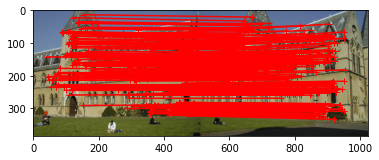

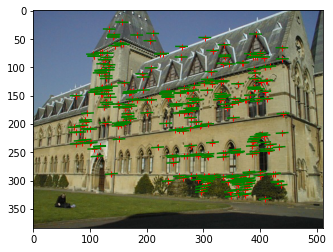

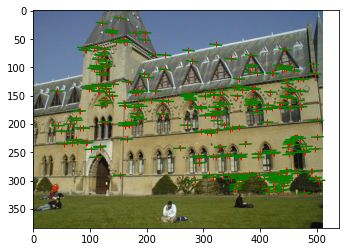

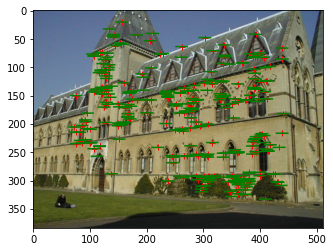

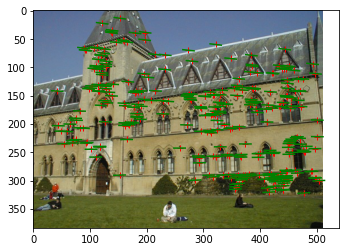

In [69]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

#### Part (2)

In [70]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(...):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    pass


# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(...)
lab2_proj = camera_calibration(...)
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(...)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(...)
print('residual in lab2:', lab2_res)

SyntaxError: invalid syntax (<ipython-input-70-bd9a38836787>, line 22)

In [49]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


#### Part (3)

In [50]:
# Write your code here for computing camera centers
def calc_camera_center(...):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>
    pass

# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(...)
lab2_c = calc_camera_center(...)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(...)
lib2_c = calc_camera_center(...)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

SyntaxError: invalid syntax (<ipython-input-50-905ef6f55138>, line 2)

#### Part (4)

In [ ]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(...):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    pass

def evaluate_points_3d(...):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    pass

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
lab_pt1 = matches_lab[:,:2]
lab_pt2 = matches_lab[:,2:]
points_3d_gt = np.loadtxt('./lab_3d.txt')
points_3d_lab = triangulation(...) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(...) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, lab_pt1, points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, lab_pt2, points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')
lib_pt1 = matches_lib[:,:2]
lib_pt2 = matches_lib[:,2:]
points_3d_lib = triangulation(...) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, lib_pt1, points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, lib_pt2, points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')